In [1]:
import numpy as np
import os
import tensorflow as tf
import copy
import sys

from pommerman.agents import BaseAgent, SimpleAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.constants import BOARD_SIZE
from pommerman.envs.v0 import Pomme

from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep

/gpfs/hpchome/novin/.conda/envs/pommerenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/gpfs/hpchome/novin/.conda/envs/pommerenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Import error NSDE! You will not be able to render --> Cannot connect to "None"


In [2]:
nr_rollouts = 500
train_data_path = './new_train_data2/'
if not os.path.isdir(train_data_path):
    os.makedirs(train_data_path)

# Gather from 4 SimpleAgents

In [ ]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])
env.seed(0)

# Add four Simple agents
agents = {}
for agent_id in range(4):
    agents[agent_id] = SimpleAgent(config["agent"](agent_id, config["game_type"]))
env.set_agents(list(agents.values()))
env.set_init_game_state(None)

# take log
# winners
winner_observations = {k: [] for k in range(4)}
winner_labels = {k: [] for k in range(4)}
winner_rewards = {k: [] for k in range(4)}

# winners tie
winnertie_observations = {k: [] for k in range(4)}
winnertie_labels = {k: [] for k in range(4)}
winnertie_rewards = {k: [] for k in range(4)}

# loosers
looser_observations = {k: [] for k in range(4)}
looser_labels = {k: [] for k in range(4)}
looser_rewards = {k: [] for k in range(4)}

# loosers tie
loosertie_observations = {k: [] for k in range(4)}
loosertie_labels = {k: [] for k in range(4)}
loosertie_rewards = {k: [] for k in range(4)}

# tie
tie_observations = {k: [] for k in range(4)}
tie_labels = {k: [] for k in range(4)}
tie_rewards = {k: [] for k in range(4)}

# all
observations = {k: [] for k in range(4)}
labels = {k: [] for k in range(4)}
rewards = {k: [] for k in range(4)}

episodes = []

def simulate(nr_rollouts=2, render=False, terminal_visualize=False):
    def close():
        if render:
            env.render(close=True)
        env.close()
    
    for i in range(nr_rollouts):
        episode_steps = 0
        done = False
        # Seed and reset the environment
        obs = env.reset()
        already_dead = [] # keep track of already dead agents
        tmp_obs = {k: [] for k in range(4)}
        tmp_labels = {k: [] for k in range(4)}
        tmp_rewards = {k: [] for k in range(4)}
        while not done:
            if render:
                env.render()
            obs_tosave = obs
            actions = env.act(obs)
            obs, reward, done, info = env.step(actions)
            # distrintuish new dead agents from already dead ones
            agents_tosave = np.where(np.array(reward) != -1)[0]
            dead_agents = np.where(np.array(reward) == -1)[0]
            for d in dead_agents:
                if d not in already_dead:
                    agents_tosave = np.append(agents_tosave, d)
                    already_dead.append(d)
            # only store observation for the alive or new dead agents
            for a in agents_tosave:
                tmp_obs[a].append(copy.deepcopy(obs_tosave[a]))
                tmp_labels[a].append(copy.deepcopy(actions[a]))
                tmp_rewards[a].append(copy.deepcopy(reward[a]))
            # visualize one agent's observation for debugging:
            if terminal_visualize:
                clear_output(wait=True)
                sys.stdout.write("rollout: %i, episode: %i \n" % (i, episode_steps))
                sys.stdout.write("%s\n" % obs_tosave[0]['board'])
                sys.stdout.write("agents:" + str(agents_tosave))
                sys.stdout.write("\nblast strength: " + str(obs_tosave[0]['blast_strength']) +
                                 ", kick: " + str(obs_tosave[0]['can_kick']) + 
                                 ", ammo: " + str(obs_tosave[0]['ammo']) + "\n")
                #sys.stdout.write("\n%s\n\n" % obs_tosave[0]['bomb_blast_strength'])
                #sys.stdout.write("%s\n\n" % obs_tosave[0]['bomb_life'])
                sys.stdout.flush()
                #sleep(0.02)
            episode_steps += 1
        print(i, ": ", info)
        episode_info = {}
        episode_info['result'] = info['result'].value
        episode_info['winner'] = info['winners'] if 'winners' in info.keys() else -1
        episode_info['length'] = episode_steps
        episodes.append(episode_info)
        
#         # visualize the episode's winner's board for debugging
#         print("game finnished")
#         print("replay..")
#         sleep(2)
#         for obs in tmp_obs[info['winners'][0]]:
#             clear_output(wait=True)
#             print(obs['board'])
#             print("")
#             sleep(0.05)
#         print(episode_steps)
#         print(len(tmp_obs[info['winners'][0]]))
#         break

        # all observations without any winner/looser filtering
        for m in range(4):
            observations[m] += tmp_obs[m]
            labels[m] += tmp_labels[m]
            rewards[m] += tmp_rewards[m]

        # with winner/looser/tie filters
        if info['result'].value == 0: # game had a winner
            winner_id = info['winners'][0]
            winner_observations[winner_id] += tmp_obs[winner_id]
            winner_labels[winner_id] += tmp_labels[winner_id]
            winner_rewards[winner_id] += tmp_rewards[winner_id]
            winnertie_observations[winner_id] += tmp_obs[winner_id]
            winnertie_labels[winner_id] += tmp_labels[winner_id]
            winnertie_rewards[winner_id] += tmp_rewards[winner_id]
            loosers = [m for m in range(4) if m != winner_id]
            for looser_id in loosers:
                looser_observations[looser_id] += tmp_obs[looser_id]
                looser_labels[looser_id] += tmp_labels[looser_id]
                looser_rewards[looser_id] += tmp_rewards[looser_id]
                loosertie_observations[looser_id] += tmp_obs[looser_id]
                loosertie_labels[looser_id] += tmp_labels[looser_id]
                loosertie_rewards[looser_id] += tmp_rewards[looser_id]
        elif info['result'].value == 2: # tied game
            for m in range(4):
                winnertie_observations[m] += tmp_obs[m]
                winnertie_labels[m] += tmp_labels[m]
                winnertie_rewards[m] += tmp_rewards[m]
                loosertie_observations[m] += tmp_obs[m]
                loosertie_labels[m] += tmp_labels[m]
                loosertie_rewards[m] += tmp_rewards[m]
                tie_observations[m] += tmp_obs[m]
                tie_labels[m] += tmp_labels[m]
                tie_rewards[m] += tmp_rewards[m]
        close() # end of this episode
        
simulate(nr_rollouts, terminal_visualize=False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0 :  {'result': <Result.Win: 0>, 'winners': [3]}
1 :  {'result': <Result.Win: 0>, 'winners': [3]}
2 :  {'result': <Result.Win: 0>, 'winners': [2]}
3 :  {'result': <Result.Tie: 2>}
4 :  {'result': <Result.Tie: 2>}
5 :  {'result': <Result.Win: 0>, 'winners': [0]}
6 :  {'result': <Result.Win: 0>, 'winners': [3]}
7 :  {'result': <Result.Win: 0>, 'winners': [1]}
8 :  {'result': <Result.Win: 0>, 'winners': [0]}
9 :  {'result': <Result.Win: 0>, 'winners': [2]}
10 :  {'result': <Result.Win: 0>, 'winners': [0]}
11 :  {'result': <Result.Tie: 2>}
12 :  {'result': <Result.Win: 0>, 'winners': [3]}
13 :  {'result': <Result.Win: 0>, 'winners': [0]}
14 :  {'result': <Result.Win: 0>, 'winners': [3]}
15 :  {'result': <Result.Win: 0>, 'winners': [3]}
16 :  {'result': <Result.Win: 0>, 'winners': [2]}
17 :  {'result': <Result.Win: 0>, 'winners': [3]}
18 :  {'result': <Result.Win: 0>, 'winners': [3]}
19 :  {'r

## replay the recorded observations/labels/rewards for debug

In [21]:
def replay_board(obs, label, agents=[0,1,2,3], ffwd=True):
    for a in agents: # iterate agents
        rollout = 0
        assert len(obs[a]) == len(label[a])
        for i, ob in enumerate(obs[a]): # iterate observations
            if ffwd and i % 1000 != 0: # display every 10 recorded frames
                continue
            sys.stdout.write("agent: %i, step: %i/%i, action: %i, reward: %i \n" % \
                             (a, i, len(label[a]), labels[a][i], rewards[a][i]))
            sys.stdout.write("%s\n" % ob['board'])
            sys.stdout.write("alive: %s\n" % ob['alive'])
            sys.stdout.write("blast strength: " + str(ob['blast_strength']) +
                             ", kick: " + str(ob['can_kick']) + 
                             ", ammo: " + str(ob['ammo']) + "\n")
            #sys.stdout.write("\n%s\n\n" % ob[i]['bomb_blast_strength'])
            #sys.stdout.write("%s\n\n" % ob[i]['bomb_life'])
            sys.stdout.flush()
            sleep(0.005 if ffwd else 0.1)
            clear_output(wait=True)

print("all recorded observations..")
sleep(2)
replay_board(observations, labels, agents=[0,1,2,3])

print("winner..")
sleep(2)
replay_board(winner_observations, winner_labels, agents=[0,1,2,3])

print("winner-tie..")
sleep(2)
replay_board(winnertie_observations, winnertie_labels, agents=[0,1,2,3])

print("looser..")
sleep(2)
replay_board(looser_observations, looser_labels, agents=[0,1,2,3])

print("looser-tie..")
sleep(2)
replay_board(loosertie_observations, loosertie_labels, agents=[0,1,2,3])

print("tie..")
sleep(2)
replay_board(tie_observations, tie_labels, agents=[0,1,2,3])

agent: 3, step: 48000/48069, action: 1, reward: 0 
[[ 0  0  0  1  1  0  0  0  0  0  1]
 [ 0  0  0  0  0  6  6  0  0  0  0]
 [ 0  0  0  0  1  1  2  2  1  0  1]
 [ 1  0  0  0  1  2  1  0  1 13  2]
 [ 1 10  1  1  0  1  1  0  0  2  1]
 [ 0  7  1  2  1  0  2  2  2  8  0]
 [ 0 12  0  1  1  2  0  1  1  0  1]
 [ 0  0  0  0  0  8  1  0  0  0  0]
 [ 0  0  1  1  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 1  0  1  2  1  0  1  0  1  1  0]]
alive: [10, 12, 13]
blast strength: 2, kick: False, ammo: 1


## Some insights

In [22]:
def nr_samples(labels):
    total = 0
    for k, v in labels.items():
        total += len(v)
    return total

print("all: ", nr_samples(labels))
print("winner: ", nr_samples(winner_labels))
print("winnertie: ", nr_samples(winnertie_labels))
print("looser: ", nr_samples(looser_labels))
print("loosertie: ", nr_samples(loosertie_labels))
print("tie: ", nr_samples(tie_labels))

all:  542955
winner:  121677
winnertie:  331501
looser:  211454
loosertie:  421278
tie:  209824


// TODO: now I just save the a balanced number of samples for each but if we want to 
    compare which dataset is better perhaps it would be better to balance number of each too!

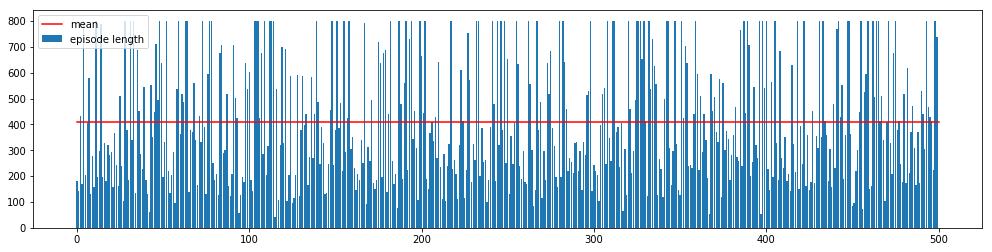

nr_ties:  131
total episodes:  500
min length:  40
max length:  801


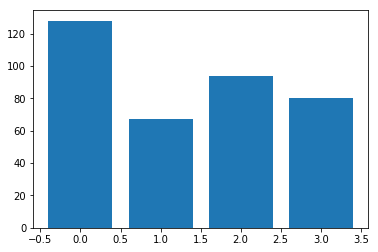

In [23]:
# episodes info
winner = []
epis_lengths = []
nr_ties = 0
for e in episodes:
    if e['winner'] != -1:
        winner.append(e['winner'][0])
    else:
        nr_ties += 1
    epis_lengths.append(e['length'])

plt.figure(figsize=(17,4))
plt.bar(range(0, len(epis_lengths)), epis_lengths)
plt.plot([0, len(epis_lengths)], [np.mean(epis_lengths), np.mean(epis_lengths)], 'r')
plt.legend(['mean', 'episode length'])
plt.show()
print("nr_ties: ", nr_ties)
print("total episodes: ", len(episodes))
print("min length: ", min(epis_lengths))
print("max length: ", max(epis_lengths))

plt.bar(range(0,4), np.bincount(winner))
plt.show()

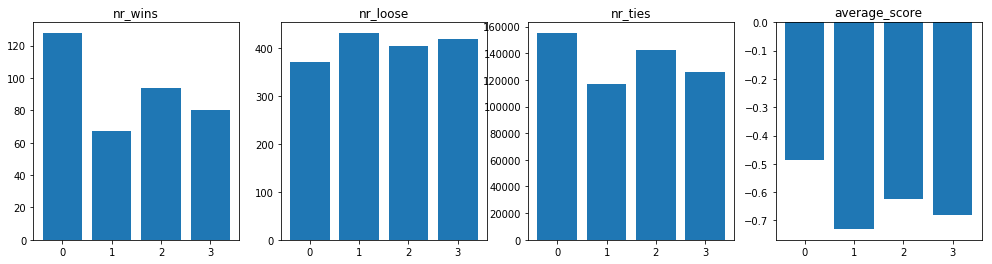

In [24]:
# rewards stats
def rewards_insight(rewards):
    nr_wins = [0] * 4
    nr_loose = [0] * 4
    nr_tie = [0] * 4
    average_score = [0] * 4

    for k in rewards.keys():
        nr_wins[k] = np.sum(np.array(rewards[k]) == 1)
        nr_loose[k] = np.sum(np.array(rewards[k]) == -1)
        nr_tie[k] = np.sum(np.array(rewards[k]) == 0)
        average_score[k] = np.sum(rewards[k])/nr_rollouts
    #     print("average score: ")
    #     print("agent ", k, ": ", average_score[k])


    plt.figure(figsize=(17,4))
    plt.subplot(141)
    plt.bar(range(0,4), nr_wins)
    plt.title('nr_wins')
    plt.subplot(142)
    plt.bar(range(0,4), nr_loose)
    plt.title('nr_loose')
    plt.subplot(143)
    plt.bar(range(0,4), nr_tie)
    plt.title('nr_ties')
    plt.subplot(144)
    plt.bar(range(0,4), average_score)
    plt.title('average_score')
    plt.show()
    
    # assert np.array_equal(np.bincount(winner), np.array(nr_wins)) # just a check/
    
rewards_insight(rewards)
# rewards_insight(winner_rewards)
# rewards_insight(winnertie_rewards)
# rewards_insight(looser_rewards)
# rewards_insight(loosertie_rewards)
# rewards_insight(tie_rewards)

all:
agent  0  actions ratio:  [0.26 0.17 0.18 0.16 0.2  0.04]
agent  1  actions ratio:  [0.3  0.18 0.14 0.15 0.19 0.03]
agent  2  actions ratio:  [0.16 0.22 0.17 0.22 0.19 0.04]
agent  3  actions ratio:  [0.29 0.17 0.17 0.19 0.16 0.03]


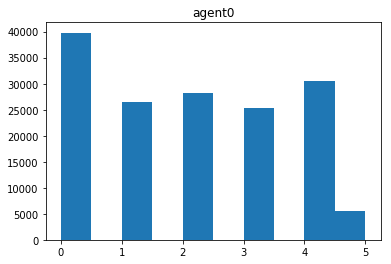

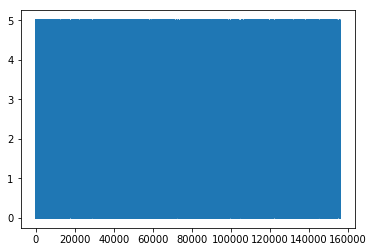

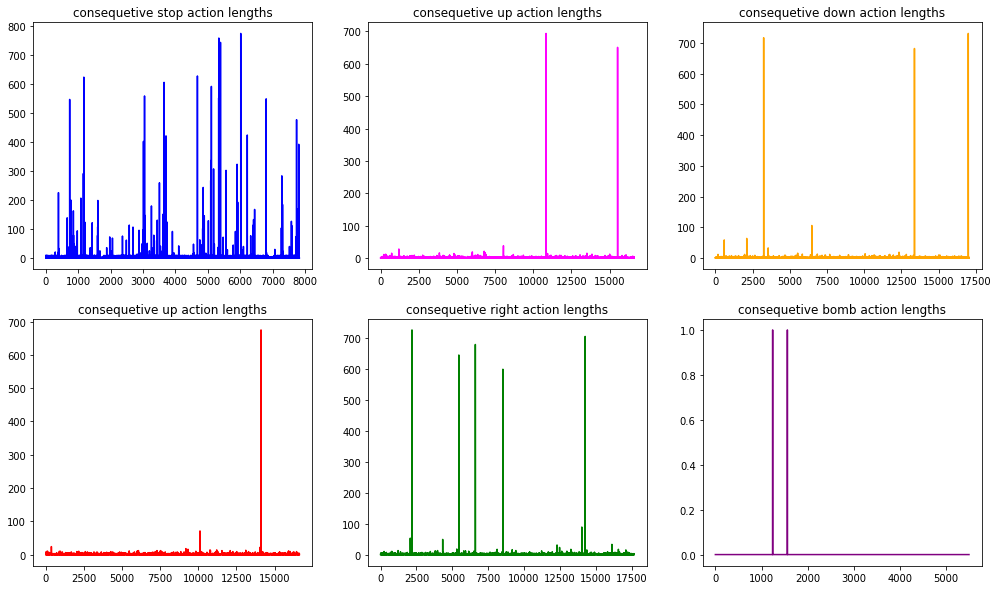

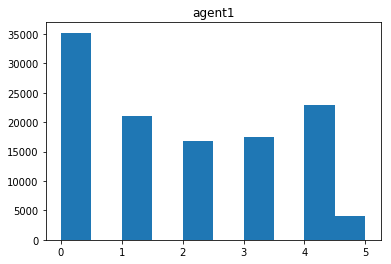

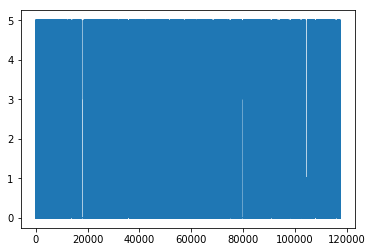

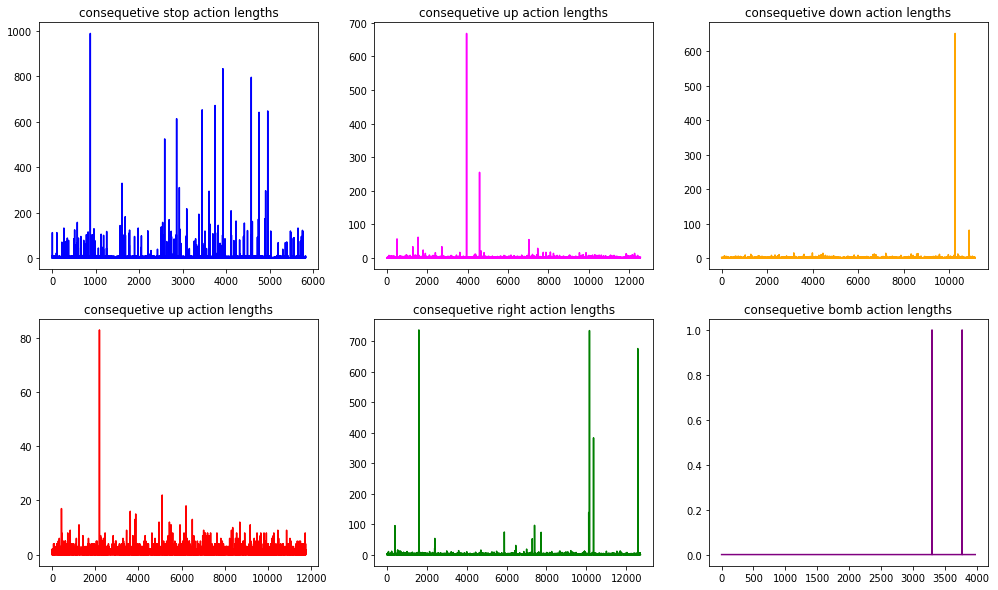

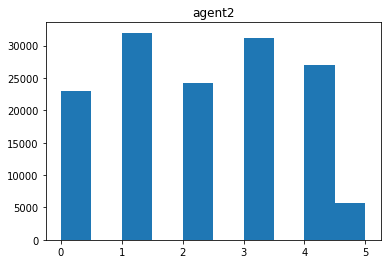

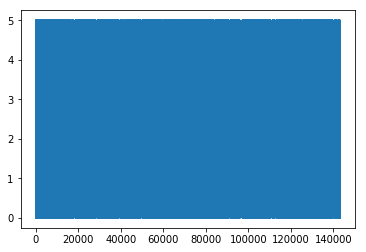

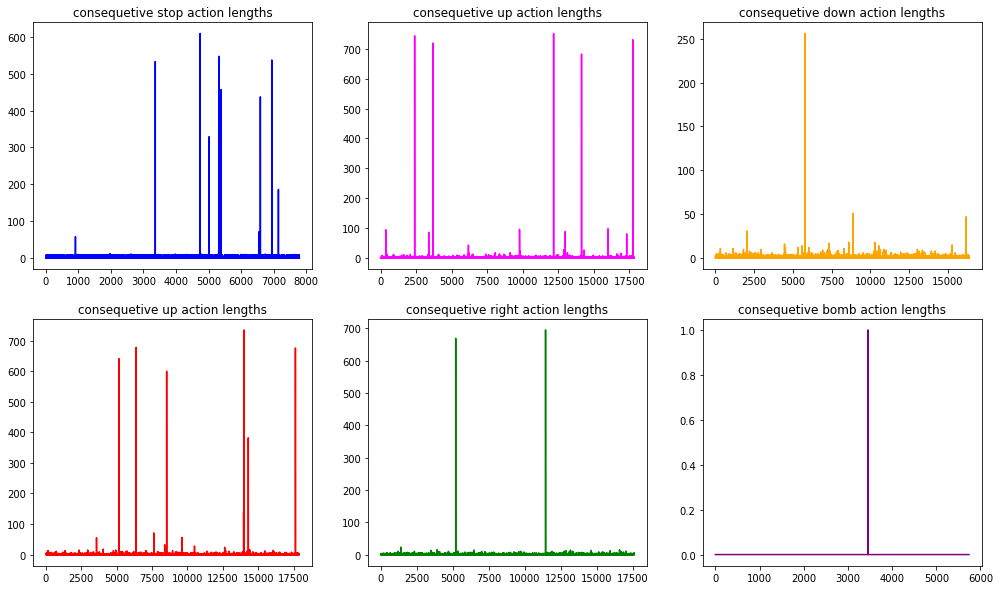

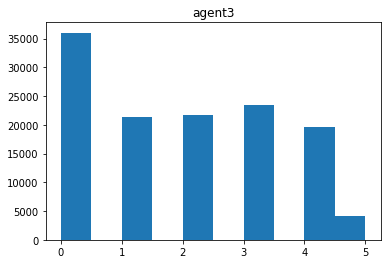

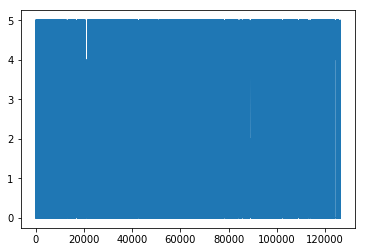

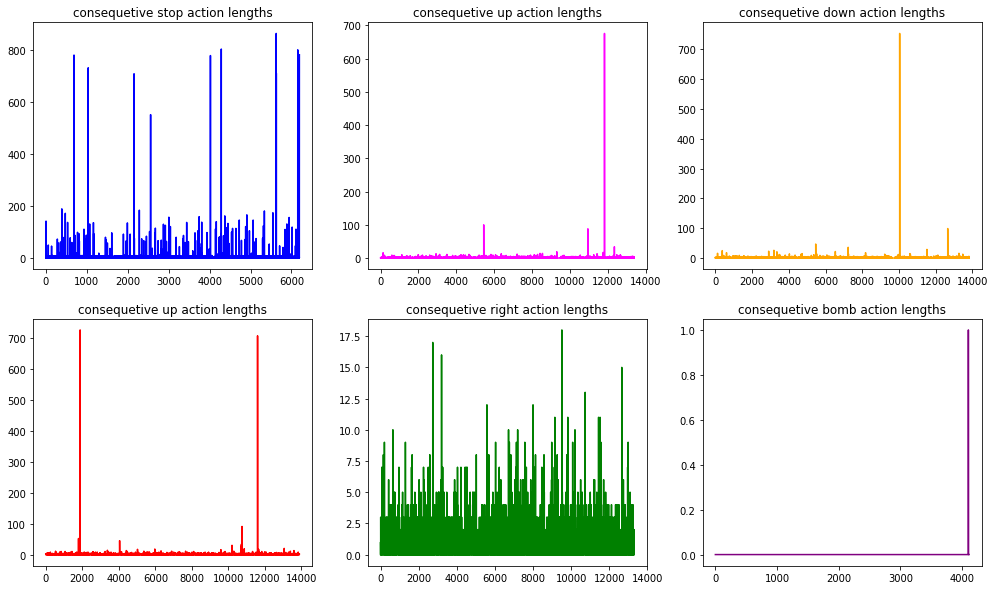


winners:
agent  0  actions ratio:  [0.25 0.17 0.18 0.17 0.19 0.04]
agent  1  actions ratio:  [0.22 0.2  0.17 0.18 0.2  0.03]
agent  2  actions ratio:  [0.14 0.21 0.19 0.21 0.2  0.04]
agent  3  actions ratio:  [0.2  0.19 0.19 0.2  0.18 0.03]


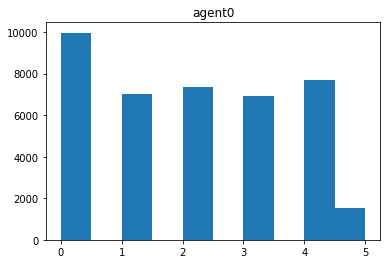

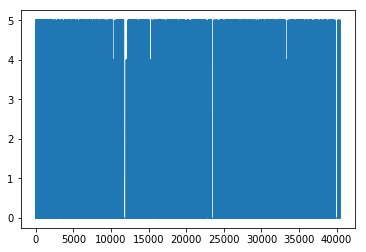

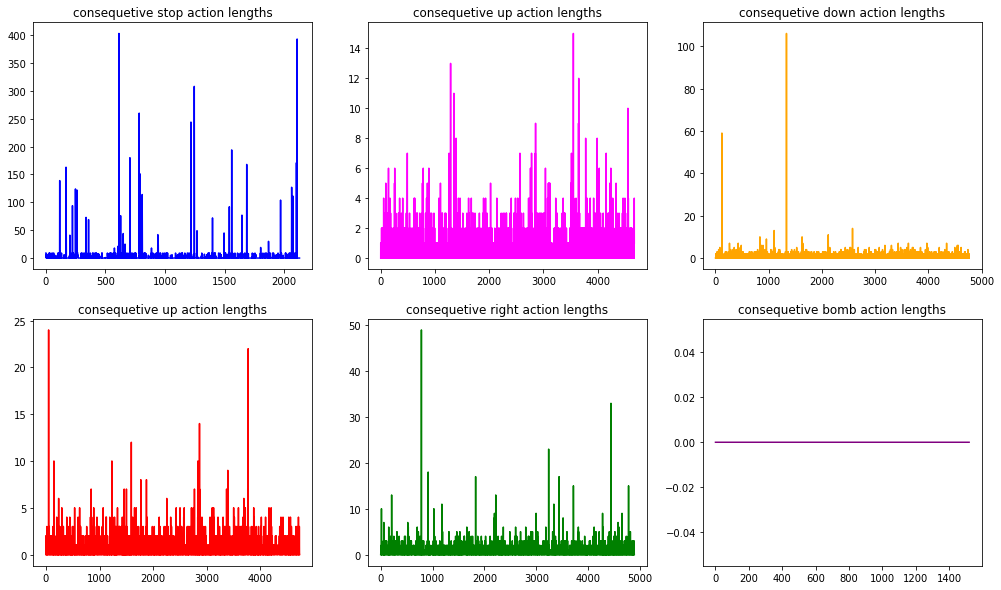

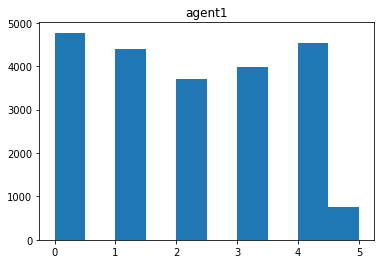

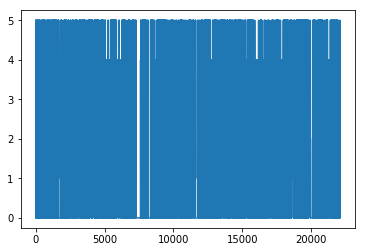

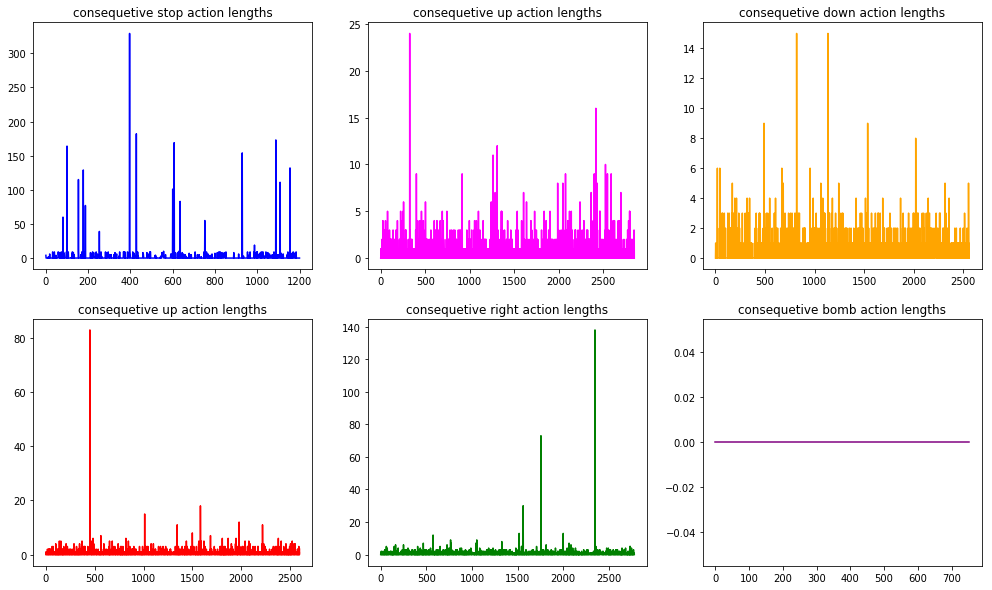

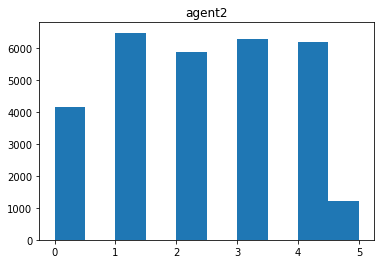

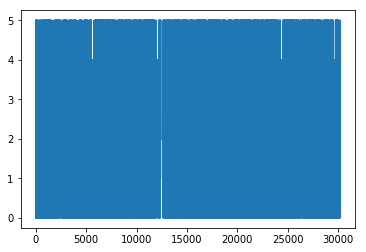

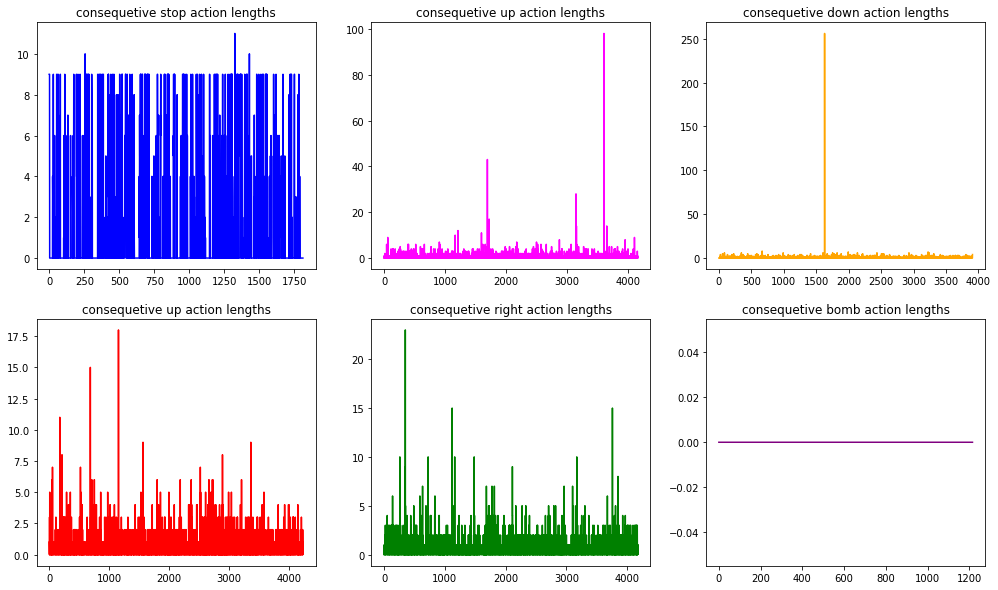

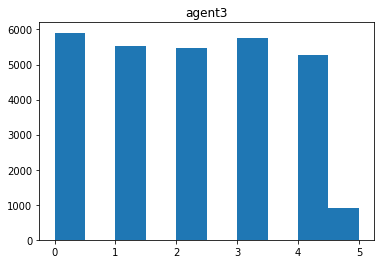

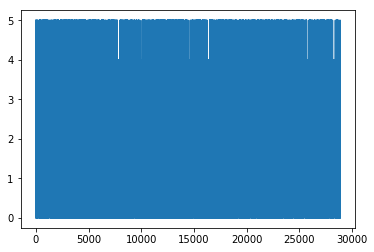

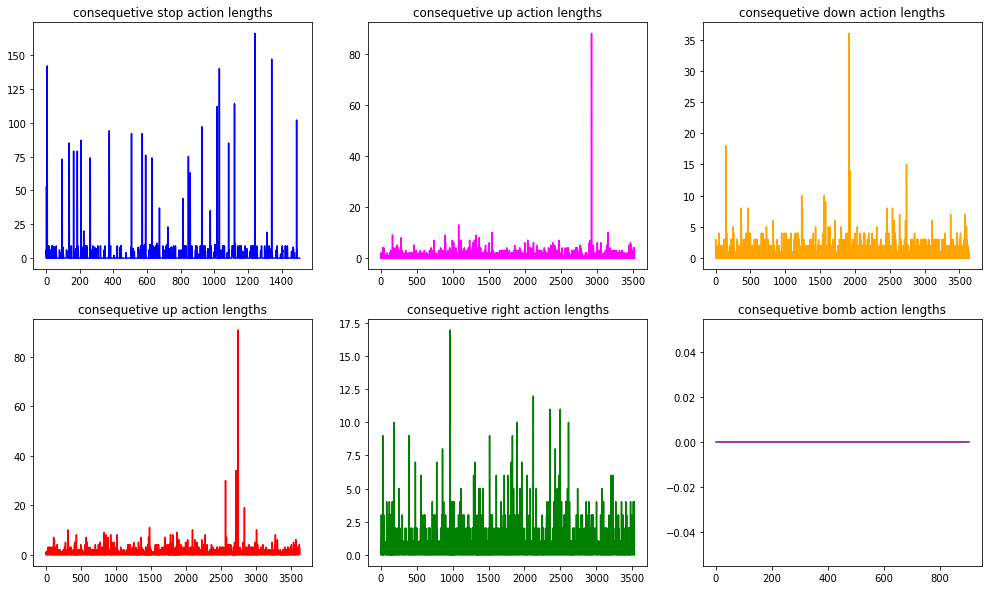


winners-tie:
agent  0  actions ratio:  [0.27 0.17 0.18 0.16 0.2  0.03]
agent  1  actions ratio:  [0.29 0.18 0.15 0.15 0.2  0.03]
agent  2  actions ratio:  [0.16 0.23 0.16 0.22 0.19 0.03]
agent  3  actions ratio:  [0.29 0.17 0.17 0.19 0.16 0.03]

loosers:
agent  0  actions ratio:  [0.22 0.18 0.19 0.17 0.2  0.05]
agent  1  actions ratio:  [0.31 0.18 0.13 0.15 0.19 0.04]
agent  2  actions ratio:  [0.16 0.21 0.18 0.21 0.19 0.05]
agent  3  actions ratio:  [0.29 0.17 0.17 0.18 0.16 0.04]

loosers-tie:
agent  0  actions ratio:  [0.26 0.17 0.18 0.16 0.2  0.03]
agent  1  actions ratio:  [0.32 0.18 0.14 0.14 0.19 0.03]
agent  2  actions ratio:  [0.17 0.23 0.16 0.22 0.18 0.04]
agent  3  actions ratio:  [0.31 0.16 0.17 0.18 0.15 0.03]

tie:
agent  0  actions ratio:  [0.29 0.16 0.18 0.15 0.2  0.02]
agent  1  actions ratio:  [0.33 0.17 0.14 0.13 0.2  0.02]
agent  2  actions ratio:  [0.17 0.24 0.15 0.23 0.18 0.03]
agent  3  actions ratio:  [0.33 0.16 0.16 0.19 0.14 0.02]


In [25]:
# actions stats and visualization
def find_nonconseq_acts(event, labels):
    """ for each action of an agent """
    matching_indices = np.where(np.array(labels) == event)[0]
    starts = []
    ends = []
    count =0
    prev_idx = -float('inf')
    for i, m in enumerate(matching_indices):
        if m-1 != prev_idx: # new stop action
            count += 1 # 
            starts.append(matching_indices[i]) # or just 'm'
            if prev_idx != -float('inf'):
                ends.append(matching_indices[i-1]) # add the end point of the previous action (i.e. stop action)
        prev_idx=m
        # if i >= bound: # for debug purpose
        # break
    ends.append(matching_indices[i])
    assert len(ends) == len(starts) # nr starts and ends must match up
    #
    event_length = [] # length of steps that consequetive stop action executed
    for i in range(count):
        event_length.append(ends[i]-starts[i])
    return matching_indices, count, starts, ends, np.array(event_length)
   
    
def plot_conseq_actions(actions_length):
    """ for one agent """
    stop_length, up_length, down_length, left_length, right_length, bomb_length = actions_length
    beg = 0
    end = -1
    plt.figure(figsize=(17,10))
    plt.subplot(231)
    plt.plot(stop_length[beg:end], 'blue')
    plt.title('consequetive stop action lengths')
    plt.subplot(232)
    plt.plot(up_length[beg:end], 'magenta')
    plt.title('consequetive up action lengths')
    plt.subplot(233)
    plt.plot(down_length[beg:end], 'orange')
    plt.title('consequetive down action lengths')
    plt.subplot(234)
    plt.plot(left_length[beg:end], 'red')
    plt.title('consequetive up action lengths')
    plt.subplot(235)
    plt.plot(right_length[beg:end], 'green')
    plt.title('consequetive right action lengths')
    plt.subplot(236)
    plt.plot(bomb_length[beg:end], 'purple')
    plt.title('consequetive bomb action lengths')
    plt.show()

def insight_on_labels(labels, plot_on = False):
    for agent, actions in labels.items():
        print("agent ", agent, " actions ratio: ", np.round(np.bincount(actions) / len(actions), 2))
    if plot_on:
        for agent, actions in labels.items():
            plt.hist(actions)
            plt.title('agent' + str(agent))
            plt.show()
            plt.plot(actions)
            plt.show()
            actions_length = []
            for i in range(6):
                _,_, starts, ends, length = find_nonconseq_acts(i, actions)
                actions_length.append(length)
            plot_conseq_actions(actions_length, )

print("all:")
insight_on_labels(labels, plot_on=True)

print("\nwinners:")
insight_on_labels(winner_labels, plot_on=True)

print("\nwinners-tie:")
insight_on_labels(winnertie_labels, plot_on=False)

print("\nloosers:")
insight_on_labels(looser_labels, plot_on=False)

print("\nloosers-tie:")
insight_on_labels(loosertie_labels, plot_on=False)

print("\ntie:")
insight_on_labels(tie_labels, plot_on=False)

# Balancing Operation

### to have balance nr samples at each corner

In [26]:
def corner_min_samples(labels):
    min_samples = float('inf')
    for agent, actions in labels.items():
        if min_samples > len(actions):
            min_samples = len(actions)
    print(min_samples)
    return min_samples

all_min = corner_min_samples(labels)
winner_min = corner_min_samples(winner_labels)
winnertie_min = corner_min_samples(winnertie_labels)
looser_min = corner_min_samples(looser_labels)
loosertie_min = corner_min_samples(loosertie_labels)
tie_min = corner_min_samples(tie_labels)

117492
22125
67921
49359
95367
45796


### balance labels with respect to the length of consequative actions

In [27]:
def balance_labels_lengthwise(labels, cut=-1, plot_on = False):
    def pick_idx(action_lengths, starts, ends):
        picked = np.empty(0)
        thresh = 12 # bomb life is also 10 - it seems to be a reasonable threshold .. 
                    # .. for any action to be executed for this duration max
        for i, al in enumerate(action_lengths):
            if al == 0: # pick non-consequetive (=0)
                picked = np.append(picked, starts[i])
            elif al <= 10: # pick consequetive (<=thresh)
                picked = np.append(picked, np.arange(starts[i], ends[i]+1))
            else: # sample from consequetive actions longer than the threshold
                #n = thresh + 5
                #nr_samples = n if n < al else al
                #sampled = np.random.choice(range(starts[i], ends[i]+1), nr_samples, replace=False)
                #picked = np.append(picked, sampled)
                picked = np.append(picked, np.arange(starts[i],starts[i]+thresh))
            #print(len(picked))
        return picked

    all_picked = [None] * 4 # nr agents

    min_sample = cut
    for agent, actions in labels.items():
        if not actions:
            continue
        print("\n#### Agent ", agent)
        # stop
        _, _, starts, ends, stop_length = find_nonconseq_acts(0, actions[:cut])
        stop_picked = pick_idx(stop_length, starts, ends)
        # up
        _, _, starts, ends, up_length = find_nonconseq_acts(1, actions[:cut])
        up_picked = pick_idx(up_length, starts, ends)
        # down
        _, _, starts, ends, down_length = find_nonconseq_acts(2, actions[:cut])
        down_picked = pick_idx(down_length, starts, ends)
        # left
        _, _, starts, ends, left_length = find_nonconseq_acts(3, actions[:cut])
        left_picked = pick_idx(left_length, starts, ends)
        # right
        _, _, starts, ends, right_length = find_nonconseq_acts(4, actions[:cut])
        right_picked = pick_idx(right_length, starts, ends)
        # bomb
        _, _, starts, ends, bomb_length = find_nonconseq_acts(5, actions[:cut])
        bomb_picked = pick_idx(bomb_length, starts, ends)

        # some stats
        print("frequency: ", \
              len(stop_picked), len(up_picked), len(down_picked), \
              len(left_picked), len(right_picked), len(bomb_picked), " => sum: ", len(actions))

        # put it all together
        all_picked[agent] = np.concatenate([stop_picked, up_picked, down_picked, left_picked, right_picked, bomb_picked])
        # make sure don't have duplicate indices otherwise something's wrong with the perofrmed process
        assert len(np.unique(all_picked[agent])) == len(all_picked[agent])

        # some stats
        print("picked indices: %i out of %i labels" % (len(all_picked[agent]), len(labels[agent])) )
        y = np.array(labels[agent])[np.sort(all_picked[agent].astype('int'))]
        print("agent ", agent, " actions ratio (before): ", np.round(np.bincount(actions) / len(actions), 2))
        print("agent ", agent, " actions ratio (after): ", np.round(np.bincount(y) / len(y), 2))

        # see now how it looks like:
        _, count1, _, _, stop_length = find_nonconseq_acts(0, y)
        _, count2, _, _, up_length = find_nonconseq_acts(1, y)
        _, count3, _, _, down_length = find_nonconseq_acts(2, y)
        _, count4, _, _, left_length = find_nonconseq_acts(3, y)
        _, count5, _, _, right_length = find_nonconseq_acts(4, y)
        _, count6, _, _, bomb_length = find_nonconseq_acts(5, y)
        actions_length = (stop_length, up_length, down_length, left_length, right_length, bomb_length)

        print("fraction of non-consequetive actions to the total action of same type: ")
        y_sum = np.bincount(y)
        print("%2.2f, %2.2f, %2.2f, %2.2f, %2.2f, %2.2f" %
              (count1/y_sum[0], count2/y_sum[1], count3/y_sum[2], \
               count4/y_sum[3], count5/y_sum[4], count6/y_sum[5]))
        
        if plot_on:
            plot_conseq_actions(actions_length)
        
    return all_picked # picked indices final


#### Agent  0
frequency:  16003 19125 19641 18862 20690 4198  => sum:  155891
picked indices: 98519 out of 155891 labels
agent  0  actions ratio (before):  [0.26 0.17 0.18 0.16 0.2  0.04]
agent  0  actions ratio (after):  [0.16 0.19 0.2  0.19 0.21 0.04]
fraction of non-consequetive actions to the total action of same type: 
0.37, 0.66, 0.66, 0.67, 0.66, 1.00


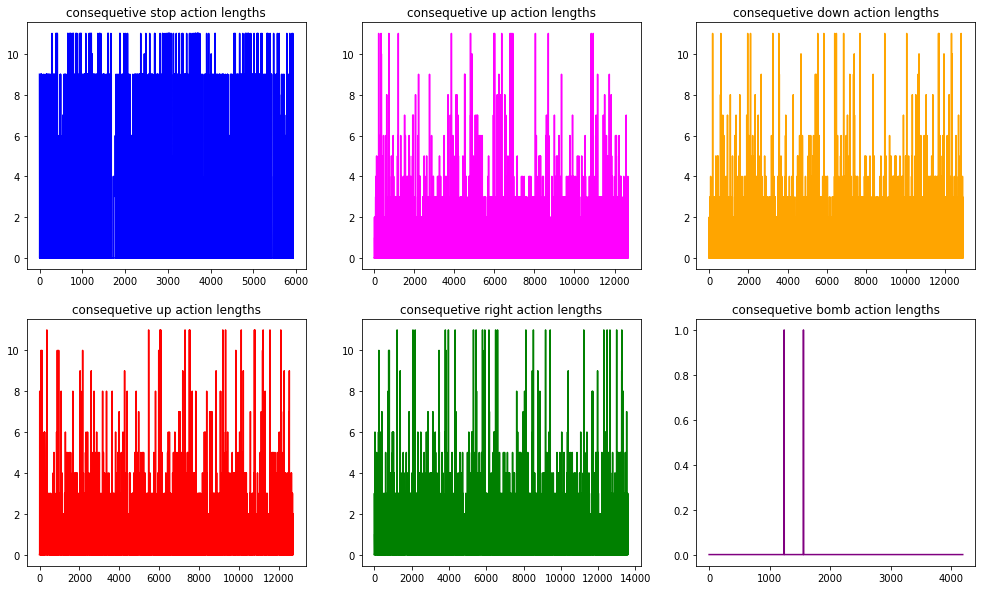


#### Agent  1
frequency:  16481 19897 16068 17431 19778 3983  => sum:  117492
picked indices: 93638 out of 117492 labels
agent  1  actions ratio (before):  [0.3  0.18 0.14 0.15 0.19 0.03]
agent  1  actions ratio (after):  [0.18 0.21 0.17 0.19 0.21 0.04]
fraction of non-consequetive actions to the total action of same type: 
0.35, 0.63, 0.69, 0.67, 0.64, 1.00


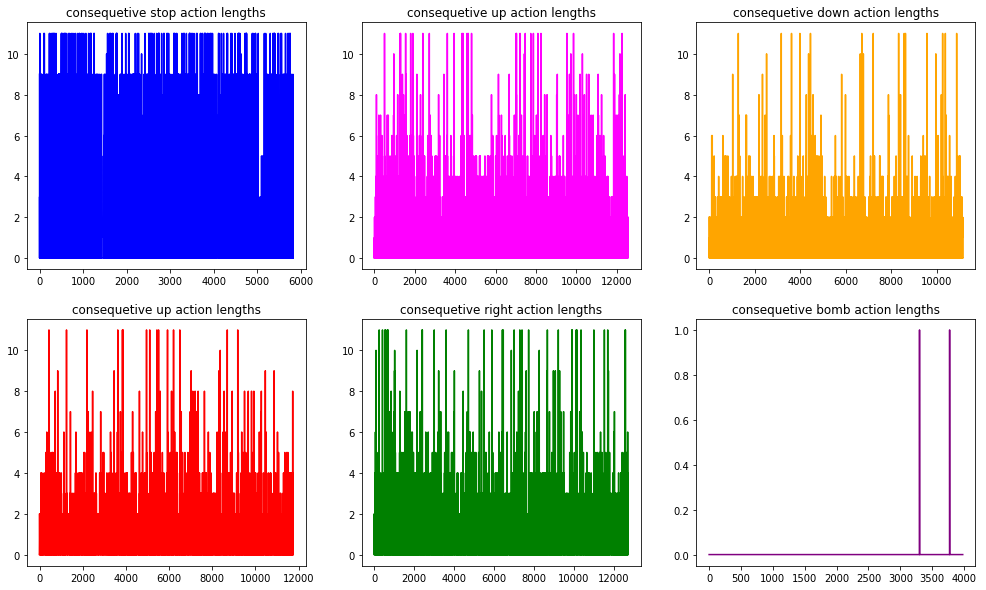


#### Agent  2
frequency:  15682 22945 19686 22463 21112 4695  => sum:  143273
picked indices: 106583 out of 143273 labels
agent  2  actions ratio (before):  [0.16 0.22 0.17 0.22 0.19 0.04]
agent  2  actions ratio (after):  [0.15 0.22 0.18 0.21 0.2  0.04]
fraction of non-consequetive actions to the total action of same type: 
0.41, 0.64, 0.68, 0.65, 0.68, 1.00


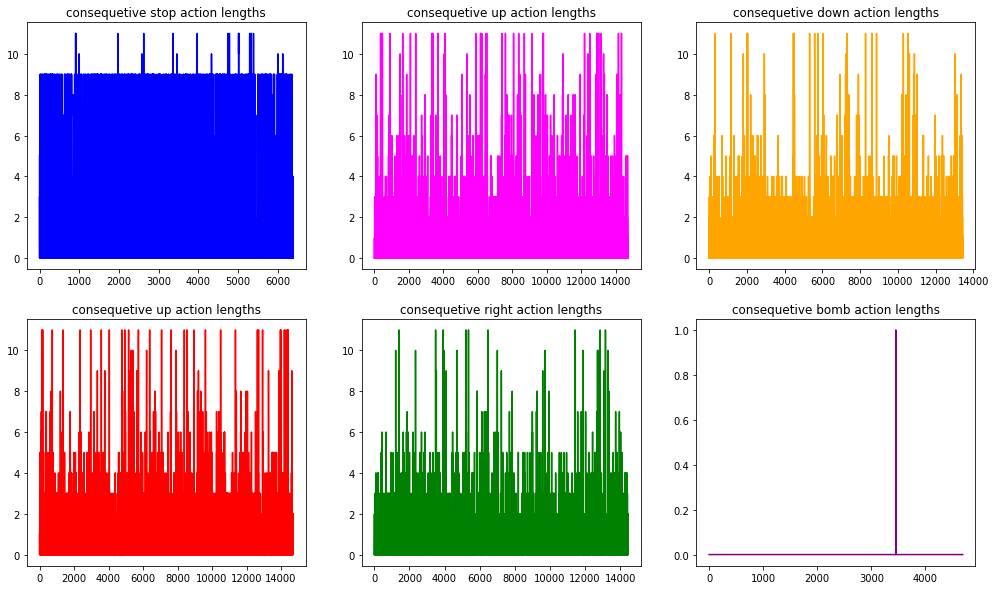


#### Agent  3
frequency:  16777 19259 19425 20477 18450 3881  => sum:  126299
picked indices: 98269 out of 126299 labels
agent  3  actions ratio (before):  [0.29 0.17 0.17 0.19 0.16 0.03]
agent  3  actions ratio (after):  [0.17 0.2  0.2  0.21 0.19 0.04]
fraction of non-consequetive actions to the total action of same type: 
0.35, 0.65, 0.67, 0.64, 0.68, 1.00


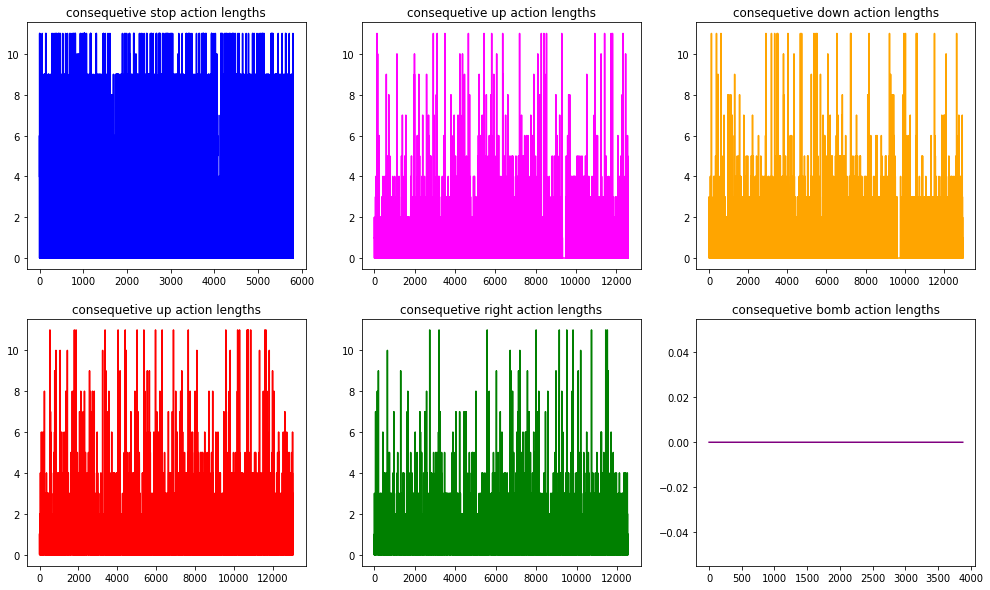

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

#### Agent  0
frequency:  3320 3776 3967 3758 4148 866  => sum:  40471
picked indices: 19835 out of 40471 labels
agent  0  actions ratio (before):  [0.25 0.17 0.18 0.17 0.19 0.04]
agent  0  actions ratio (after):  [0.17 0.19 0.2  0.19 0.21 0.04]
fraction of non-consequetive actions to the total action of same type: 
0.35, 0.68, 0.66, 0.68, 0.65, 1.00

#### Agent  1
frequency:  2867 4378 3690 3894 4313 754  => sum:  22125
picked indices: 19896 out of 22125 labels
agent  1  actions ratio (before):  [0.22 0.2  0.17 0.18 0.2  0.03]
agent  1  actions ratio (after):  [0.14 0.22 0.19 0.2  0.22 0.04]
fraction of non-consequetive actions to the total action of same type: 
0.42, 0.65, 0.69, 0.67, 0.64, 1.00

#### Agent  2
frequency:  3005 4652 4148 4585 4536 888  => sum:  30210
picked indices: 21814 out of 30210 labels
agent  2  actions ratio (before):  [0.14 0.21 0.19 0.21 0.2  0.04]
agent  2  actions ratio (after

In [28]:
all_indices = balance_labels_lengthwise(labels, cut=all_min, plot_on=True)
print(">>>>"*20)
winner_indices = balance_labels_lengthwise(winner_labels, cut=winner_min, plot_on=False)
print(">>>>"*20)
winnertie_indices = balance_labels_lengthwise(winnertie_labels, cut=winnertie_min, plot_on=False)
print(">>>>"*20)
looser_indices = balance_labels_lengthwise(looser_labels, cut=looser_min, plot_on=False)
print(">>>>"*20)
loosertie_indices = balance_labels_lengthwise(loosertie_labels, cut=loosertie_min, plot_on=False)
print(">>>>"*20)
tie_indices = balance_labels_lengthwise(tie_labels, cut=tie_min, plot_on=False)

In [29]:
def save_indices(observations, labels, rewards, indices, name):
    obs = np.empty((0))
    y = np.empty((0))
    r = np.empty((0))
    total_len = 0
    for agent, lbl in labels.items():
        ind = np.sort(indices[agent].astype('int'))
        total_len += len(ind)
        obs = np.append(obs, np.array(observations[agent])[ind])
        y = np.append(y, np.array(lbl)[ind])
        r = np.append(r, np.array(rewards[agent])[ind])
    assert obs.shape[0] == total_len
    assert y.shape[0] == total_len
    np.save(train_data_path + "obs_" + name, obs)
    np.save(train_data_path + "labels_" + name, y)
    np.save(train_data_path + "rewards_" + name, r)
    return obs, y, r

In [ ]:
# np.array(rewards[0])[[0,1,2]]

In [30]:
obs1, y1, r1 = save_indices(observations, labels, rewards, all_indices, 'all')
obs2, y2, r2 = save_indices(winner_observations, winner_rewards, winner_labels, winner_indices, 'winner')
obs3, y3, r3 = save_indices(winnertie_observations, winnertie_rewards, winnertie_labels, winnertie_indices, 'winnertie')
obs4, y4, r4 = save_indices(looser_observations, looser_rewards, looser_labels, looser_indices, 'looser')
obs5, y5, r5 = save_indices(loosertie_observations, loosertie_rewards, loosertie_labels, loosertie_indices, 'loosertie')
obs6, y6, r6 = save_indices(tie_observations, tie_rewards, tie_labels, tie_indices, 'tie')
# np.save(train_data_path + 'episodes_info', episodes)

In [31]:
# some final stats

print(obs1.shape)
print(obs2.shape)
print(obs3.shape)
print(obs4.shape)
print(obs5.shape)
print(obs6.shape)

(397009,)
(81909,)
(217713,)
(180137,)
(312763,)
(133967,)


In [ ]:
# store the rewards and later use it as a means for weighting learning

In [32]:
def replay_board2(obs, label, reward, ffwd=True):
    for i, ob in enumerate(obs): # iterate observations
        if ffwd and i % 500 != 0: # display every 10 recorded frames
            continue
        sys.stdout.write("sample: %i/%i, action: %i, reward: %i \n" % \
                         (i, label.shape[0], label[i], reward[i]))
        sys.stdout.write("%s\n" % ob['board'])
        sys.stdout.write("alive: %s\n" % ob['alive'])
        sys.stdout.write("blast strength: " + str(ob['blast_strength']) +
                         ", kick: " + str(ob['can_kick']) + 
                         ", ammo: " + str(ob['ammo']) + "\n")
        #sys.stdout.write("\n%s\n\n" % ob[i]['bomb_blast_strength'])
        #sys.stdout.write("%s\n\n" % ob[i]['bomb_life'])
        sys.stdout.flush()
        if reward[i] == -1:
            sleep(1)
        else:
            sleep(0.009 if ffwd else 0.1)
        clear_output(wait=True)

In [33]:
## Replay before the final result to make sure of its shoundness

print("all recorded observations..")
sleep(2)
replay_board2(obs1, y1, r1)

print("winner..")
sleep(2)
replay_board2(obs2, y2, r2)

print("winner-tie..")
sleep(2)
replay_board2(obs3, y3, r3)

print("looser..")
sleep(2)
replay_board2(obs4, y4, r4)

print("looser-tie..")
sleep(2)
replay_board2(obs5, y5, r5)

print("tie..")
sleep(2)
replay_board2(obs6, y6, r6)

sample: 133500/133967, action: 0, reward: 2 
[[ 0  0  0  0  1  1  0  0  2  1  2]
 [10  0  0  0  2  2  2  0  0  0  1]
 [ 0  0  0  1  0  1  1  1  0 13  2]
 [ 0  0  1  0  0  2  0  1  1  0  1]
 [ 1  2  0  0  0  2  0  2  1  2  1]
 [ 1  2  1  2  2  0  2  1  1  2  2]
 [ 0  2  1  0  0  2  0  1  2  2  2]
 [ 0  0  1  1  2  1  1  0  1  0  1]
 [ 2  0  0  1  1  1  2  1  0  0  2]
 [ 1  0 11  0  2  2  2  0  0 12  2]
 [ 2  1  2  1  1  2  2  1  2  2  0]]
alive: [10, 11, 12, 13]
blast strength: 2, kick: False, ammo: 1


In [ ]:
# count_all = 0
# count_winning = 0
# count_loosing = 0
# count_tie = 0

# for i in range(4):
#     count_all += np.sum(np.array(rewards[i]) != 0)
#     count_loosing += np.sum(np.array(looser_rewards[i]) != 0)
#     count_winning += np.sum(np.array(winner_rewards[i]) != 0)
    
# print(count_all)
# print(count_winning)
# print(count_loosing)
# print("Rewards and count of episodes match up!")

asd
